# Bayesian UQ-SINDy

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps
import arviz as az

In [3]:
# set seed for reproducibility
np.random.seed(123)

## Harmonic oscillator

In [4]:
# set up a class that defines a harmonic oscillator
class HarmonicOscillator:
    def __init__(self, zeta=0.1, omega0=2*np.pi, f=None):
        # internalise the model parameters.
        self.zeta = zeta
        self.omega0 = omega0
        if f is None:
            self.f = lambda t: 0
        else:
            self.f = f

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([y[1],
                         -2*self.zeta*self.omega0*y[1] - self.omega0**2*y[0] + self.f(t)])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [5]:
# set some hyperparameters.
t_span = [0, 5]
t_eval = np.linspace(*t_span, 50)
y0 = np.array([1,0])

# initialise the model and solve.
f = lambda t: 2*np.sin(2*np.pi*t)
my_model = HarmonicOscillator(f=f)
sol = my_model.solve(t_span=t_span, y0=y0, t_eval=t_eval)

In [6]:
# the noise level.
noise = 0.3

# extract the timesteps and perturb the solution with noise.
t = sol.t
x = sol.y[0,:] + 0.2*np.random.normal(scale=noise, size=sol.t.size)
v = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

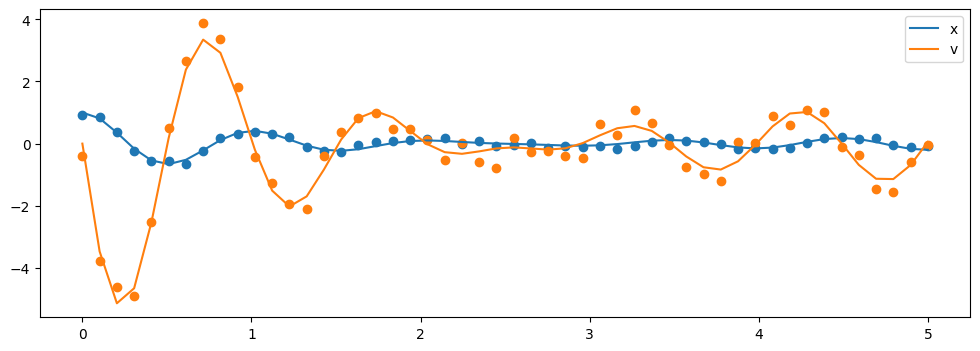

In [7]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "x")
plt.scatter(t, x)
plt.plot(sol.t, sol.y[1,:], label="v")
plt.scatter(t, v)
plt.legend()
plt.show()

## Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [8]:
# set sampler hyperparameters
sampling_seed = 123

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 1000
    num_samples = 10000
    num_chains = 2

### Use the approximate (fast) method.

In [9]:
# initialise the approximate Sparse Bayesian Regression optimizer.
approximate_optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                                          num_samples=num_samples,
                                          mcmc_kwargs={"seed": sampling_seed,
                                                       "num_chains": num_chains},
                                          exact=False)

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
approximate_sindy = ps.SINDy(approximate_optimizer, feature_library, feature_names=['x', 'v', 'f'])
approximate_sindy.fit(np.c_[x, v], t=t, u=f(t))

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'v', 'f'],
      optimizer=SBR(exact=False, integrator_kwargs={},
                    mcmc_kwargs={'num_chains': 2, 'seed': 123},
                    num_samples=10000))

In [10]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return approximate_sindy.predict(x=_y,u=f(t))

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

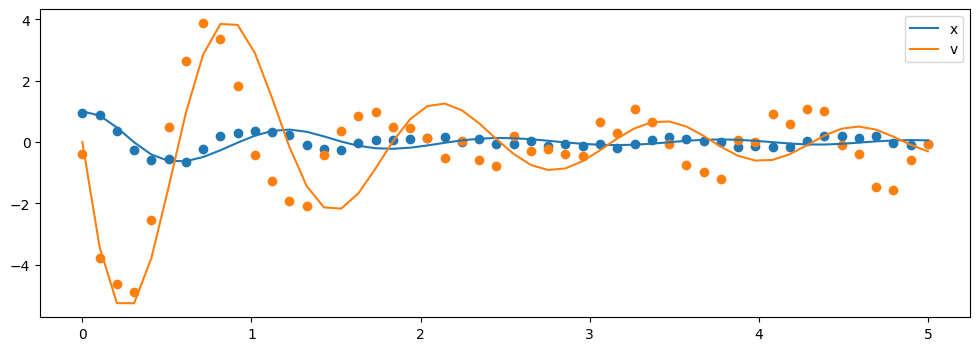

In [11]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "x")
plt.scatter(t, x)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="v")
plt.scatter(t, v)

plt.legend()
plt.show()

### Get MCMC diagnostics from the approximate method

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [12]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(approximate_optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.029,0.197,-0.379,0.421,0.004,0.003,1148.0,1144.0,1.00
"beta[0, 1]",0.025,0.353,-0.640,0.727,0.008,0.006,434.0,1931.0,1.01
"beta[0, 2]",0.711,0.302,0.049,1.193,0.042,0.030,74.0,68.0,1.03
"beta[0, 3]",-0.048,0.154,-0.387,0.188,0.022,0.015,72.0,72.0,1.04
"beta[0, 4]",0.076,0.575,-0.763,1.337,0.028,0.021,578.0,358.0,1.00
"beta[0, 5]",0.024,0.226,-0.416,0.488,0.012,0.009,165.0,2474.0,1.02
"beta[0, 6]",0.024,0.363,-0.742,0.694,0.016,0.014,358.0,605.0,1.01
"beta[0, 7]",-0.019,0.062,-0.141,0.101,0.003,0.002,473.0,1212.0,1.00
"beta[0, 8]",0.023,0.105,-0.164,0.236,0.005,0.003,309.0,2817.0,1.01
"beta[0, 9]",-0.007,0.105,-0.232,0.195,0.005,0.004,243.0,1291.0,1.01


[]

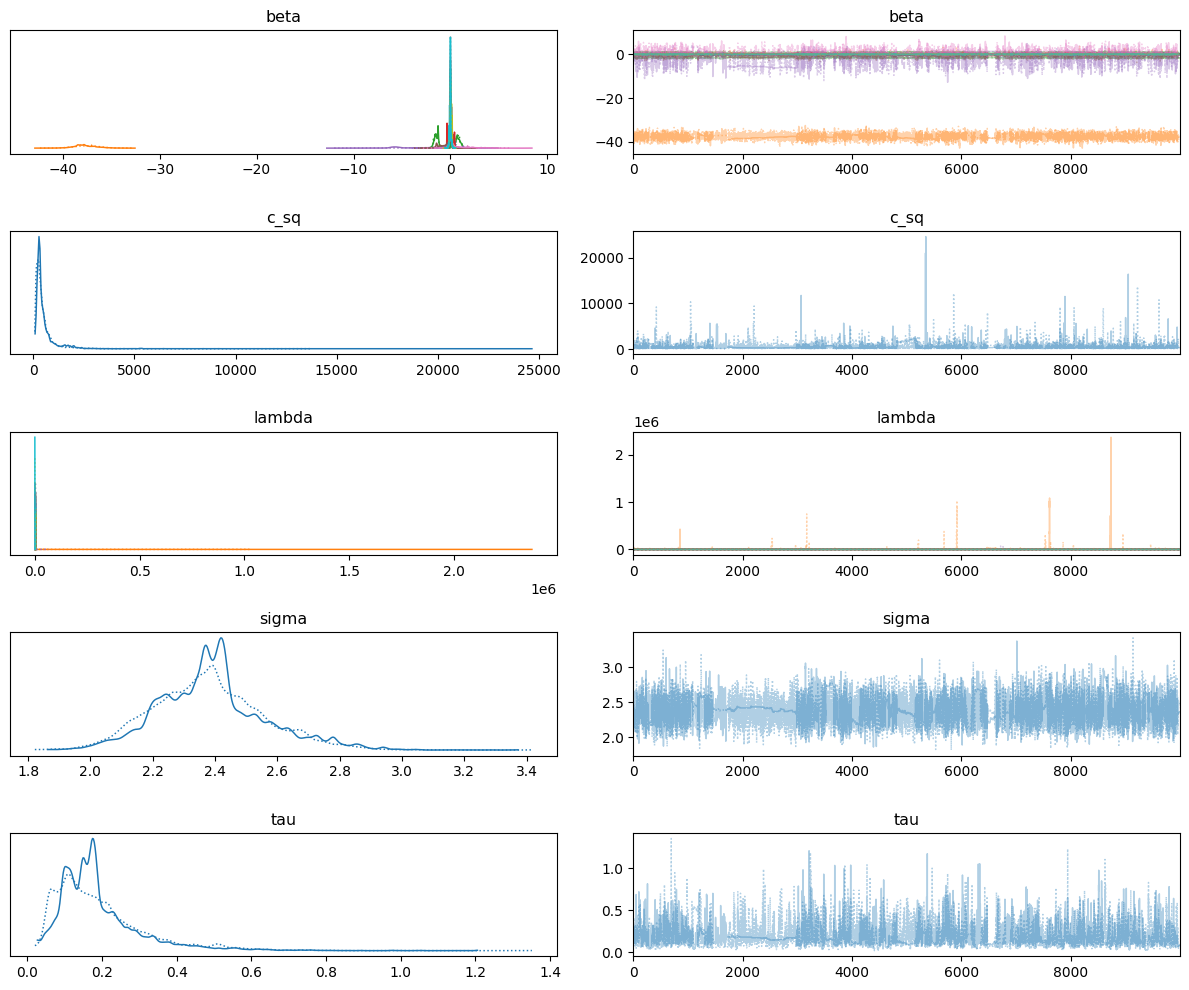

In [13]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()

In [14]:
posterior_mean = {key: value.mean(axis=0) for key, value in approximate_optimizer.mcmc_.get_samples().items()}

### Use the exact method.

In [23]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains,
                                           "initial_values": posterior_mean},
                              integrator_kwargs={"dt": 0.1},
                              )

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['x', 'v', 'f'])
sindy.fit(np.c_[x, v], t=t, u=f(t))

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'v', 'f'],
      optimizer=SBR(integrator_kwargs={'dt': 0.1},
                    mcmc_kwargs={'initial_values': {'beta': Array([[ 2.91053330e-02,  2.54958901e-02,  7.11043996e-01,
        -4.78333906e-02,  7.57955637e-02,  2.41900533e-02,
         2.36796404e-02, -1.90272331e-02,  2.29799018e-02,
        -6.66628989e...
        2.60138987e+00, 1.66205778e+00, 1.96351254e+00, 8.20824036e-01,
        1.12871977e+00, 1.24490157e+00],
       [1.47146737e+00, 2.49224141e+03, 1.60668246e+01, 1.45439083e+00,
        1.93993108e+02, 3.50566751e+00, 7.85167824e+00, 7.87026837e-01,
        1.02868801e+00, 1.09840785e+00]], dtype=float64),
                                                    'sigma': Array(2.3836697, dtype=float64),
                                                    'tau': Array(0.1917786, dtype=float64)},
                                 'num_chains': 2, 'seed': 123},
                    num_samples=10000))

In [24]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y, u=f(t))

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

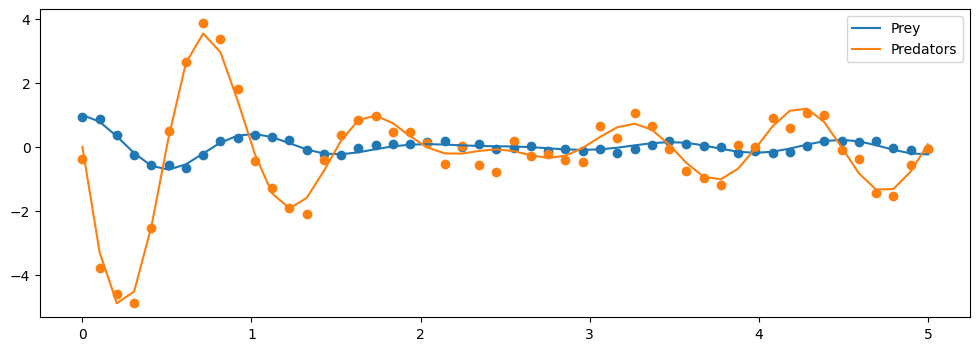

In [25]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, x)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, v)

plt.legend()
plt.show()

### Get MCMC diagnostics from the exact method

In [26]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.025,0.077,-0.109,0.194,0.002,0.001,2209.0,1951.0,1.00
"beta[0, 1]",-0.146,0.377,-1.208,0.309,0.015,0.011,1294.0,669.0,1.00
"beta[0, 2]",1.025,0.099,0.840,1.209,0.002,0.002,2000.0,6152.0,1.00
"beta[0, 3]",0.005,0.013,-0.015,0.036,0.000,0.000,1033.0,1377.0,1.00
"beta[0, 4]",-0.262,0.501,-1.401,0.384,0.014,0.010,1491.0,2100.0,1.00
"beta[0, 5]",-0.032,0.165,-0.381,0.295,0.003,0.002,3147.0,4751.0,1.00
"beta[0, 6]",0.088,0.274,-0.384,0.694,0.006,0.005,3148.0,1965.0,1.00
"beta[0, 7]",-0.001,0.016,-0.034,0.032,0.000,0.000,1543.0,2427.0,1.00
"beta[0, 8]",0.010,0.025,-0.035,0.062,0.001,0.000,1657.0,713.0,1.00
"beta[0, 9]",-0.015,0.040,-0.103,0.051,0.001,0.001,2208.0,2001.0,1.00


[]

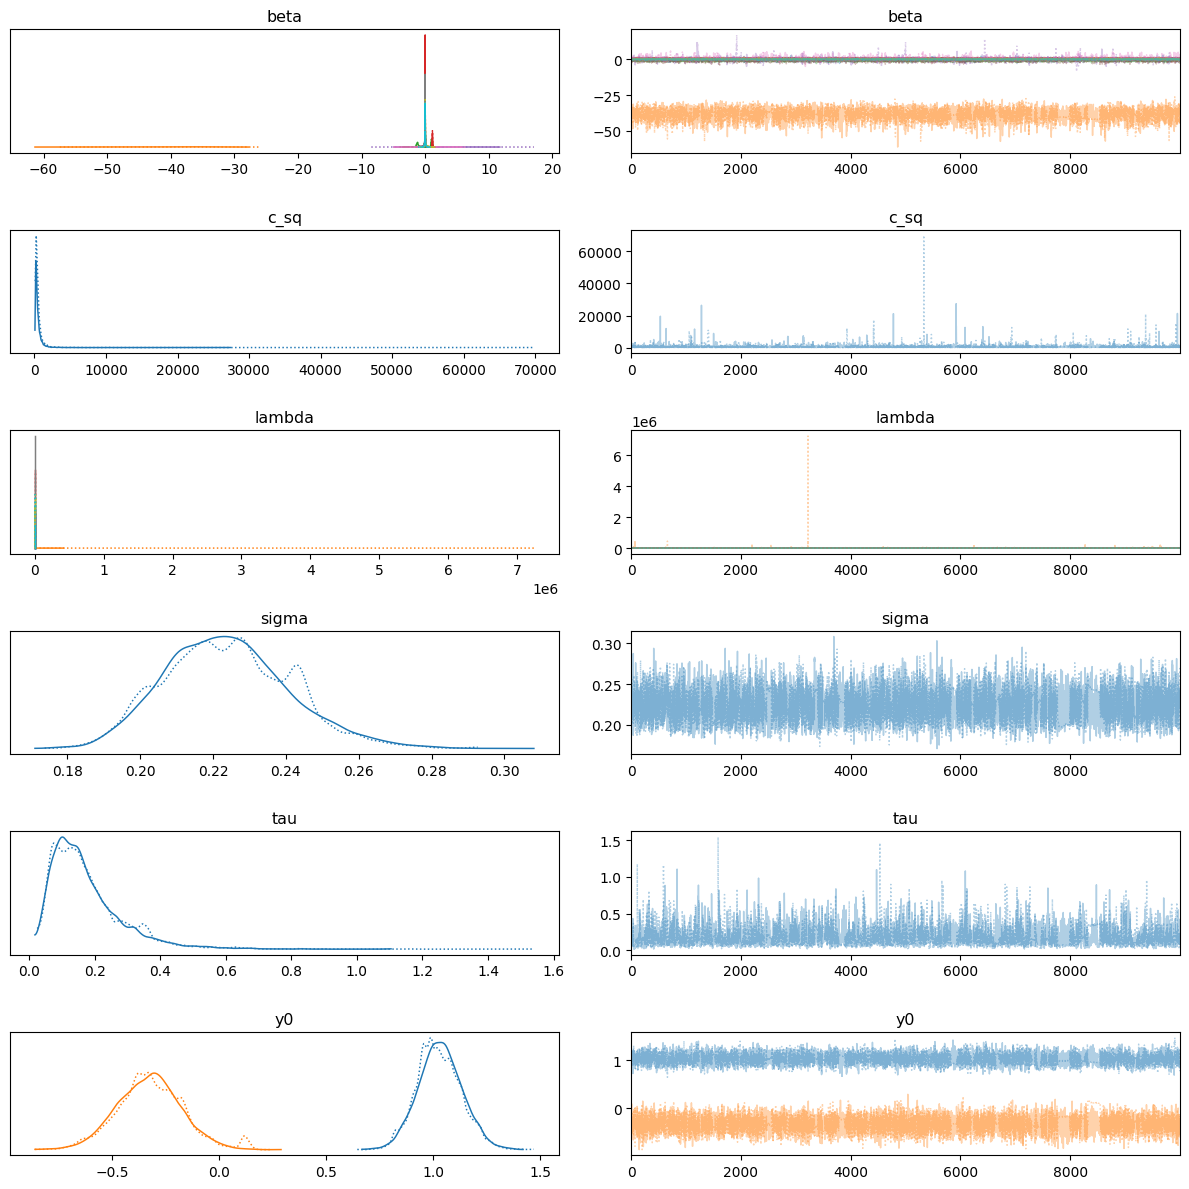

In [27]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()